In [2]:
!pip install pytorch-forecasting
!pip install shap

In [ ]:
#useful imports
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=12)
import pandas as pd
pd.set_option('display.precision', 12)
from sklearn import *
import sys
import subprocess
from datetime import datetime, timedelta
import netCDF4
import time
from functools import partial
import os
from math import *
from scipy.ndimage import binary_dilation
import torch as th
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data.dataset import TensorDataset
from typing import Any, Callable, Dict, List, Optional, Tuple, Union
from pytorch_forecasting.metrics.base_metrics import MultiHorizonMetric
import torch as th
from torch.utils.data import TensorDataset
import shap



# Ensure that working directory is forecast_rodeo
if os.path.basename(os.getcwd()) == "experiments":
    # Navigate to forecast_rodeo
    os.chdir(os.path.join("..",".."))
if os.path.basename(os.getcwd()) != "forecast_rodeo_upgrade":
    raise Exception("You must be in the forecast_rodeo_upgrade folder")

# Adds 'experiments' folder to path to load experiments_util
sys.path.insert(0, 'src/experiments')
# Load general utility functions
from experiments_util import *

#####

# Choose target
gt_id = "contest_precip" # "contest_precip" or "contest_tmp2m"
target_horizon = "56w" # "34w" or "56w"

# Create list of official contest submission dates in YYYYMMDD format
submission_dates = [datetime(y,4,18)+timedelta(14*i) for y in range(2011,2018) for i in range(26)]
submission_dates = ['{}{:02d}{:02d}'.format(date.year, date.month, date.day) for date in submission_dates]
submission_dates = [datetime.strptime(str(d), "%Y%m%d") for d in submission_dates]
submission_dates = pd.Series(submission_dates)

# Create list of target dates corresponding to submission dates in YYYYMMDD format
target_dates = pd.Series([get_target_date('{}{:02d}{:02d}'.format(date.year, date.month, date.day), target_horizon) for date in submission_dates])

# Find all unique target day-month combinations
target_day_months = pd.DataFrame({'month' : target_dates.dt.month, 
                                  'day': target_dates.dt.day}).drop_duplicates()

#####

from experiments_util import *
# Load functionality for fitting and predicting
#from fit_and_predict import *
# Load functionality for evaluation
from skill import *
# Load functionality for stepwise regression
from stepwise_util import *
from tools import *

hindcast_features = False if len(sys.argv) < 6 else (sys.argv[5] == "True")
print(hindcast_features)
measurement_variable = get_measurement_variable(gt_id) # 'tmp2m' or 'precip'
gt_col = measurement_variable
clim_col = measurement_variable+"_clim"
anom_col = get_measurement_variable(gt_id)+"_anom" # 'tmp2m_anom' or 'precip_anom'

# anom_inv_std_col: column name of inverse standard deviation of anomalies for each start_date
anom_inv_std_col = anom_col+"_inv_std"

# Default regression parameter values

# anom_scale_col: multiply anom_col by this amount prior to prediction
# (e.g., 'ones' or anom_inv_std_col)
anom_scale_col = 'ones'
# pred_anom_scale_col: multiply predicted anomalies by this amount
# (e.g., 'ones' or anom_inv_std_col)
pred_anom_scale_col = 'ones'
# choose first year to use in training set # (before 1979 = bad)
first_train_year = 1979 if gt_id == 'contest_precip' else 1979
# columns to group by when fitting regressions (a separate regression
# is fit for each group); use ['ones'] to fit a single regression to all points
group_by_cols = ['lat', 'lon']
# base_col: column which should be subtracted from gt_col prior to prediction
# (e.g., this might be clim_col or a baseline predictor like NMME)
base_col = 'zeros'
#
# Default stepwise parameter values
#
# Define candidate predictors
initial_candidate_x_cols = default_stepwise_candidate_predictors(gt_id, target_horizon, hindcast=hindcast_features)
# Copy the list of candidates for later modification
candidate_x_cols = initial_candidate_x_cols[:]
# Skill threshold for what counts as a similar year
similar_years_threshold = 0.1
# Tolerance for convergence: if improvement is less than tolerance, terminate.
tolerance = 0.01
# Whether to use margin days (days around the target date)
use_margin = False


##########

#load the considered timelist
extract_time = th.load('results/matrix/time.tensor')
print(extract_time.shape)

extract_time = np.array(extract_time).tolist()
datetime_objects = []
for timestamp in extract_time:
    # Convert the nanosecond timestamp to seconds
    timestamp_seconds = timestamp / 1e9

    # Convert the timestamp to a datetime object
    dt = datetime.fromtimestamp(timestamp_seconds)
    datetime_objects.append(dt)

datetime_objects = np.array(datetime_objects)
print(datetime_objects)


##########

#to run it on GPU
device = th.device("cuda" if th.cuda.is_available() else "cpu")

if gt_id == "contest_tmp2m":
    if target_horizon == "56w":
        indexes = ['lat', 'lon', 'start_date', 'rhum_shift44', 'pres_shift44',
           'GPP_shift44', 'RECO_shift44', 'CASM_soil_moisture_shift44',
           'nmme_wo_ccsm3_nasa', 'nmme0_wo_ccsm3_nasa', 'tmp2m_clim', 'tmp2m_anom',
           'tmp2m_shift43', 'tmp2m_shift43_anom', 'tmp2m_shift86',
           'tmp2m_shift86_anom', 'mei_shift59', 'phase_shift31',
           'sst_2010_1_shift44', 'sst_2010_2_shift44', 'sst_2010_3_shift44',
           'icec_2010_1_shift44', 'icec_2010_2_shift44', 'icec_2010_3_shift44',
           'wind_hgt_10_2010_1_shift44', 'wind_hgt_10_2010_2_shift44', 'CASM', 'GPP', 'RECO', 'elevation', 'ElNino1', 'ElNino34', 'ElNino4'] #####ADD tmp2m forgotten
        data = th.load('results/matrix/data_tmp2m56_new.tensor')
    if target_horizon == "34w":
        indexes = ['lat','lon','start_date','rhum_shift30','pres_shift30',
               'GPP_shift30','RECO_shift30','CASM_soil_moisture_shift29',
               'nmme_wo_ccsm3_nasa','nmme0_wo_ccsm3_nasa','tmp2m_clim','tmp2m_anom',
               'tmp2m_shift29','tmp2m_shift29_anom','tmp2m_shift58',
               'tmp2m_shift58_anom', 'mei_shift45','phase_shift17',
               'sst_2010_1_shift30','sst_2010_2_shift30','sst_2010_3_shift30',
               'icec_2010_1_shift30','icec_2010_2_shift30','icec_2010_3_shift30',
               'wind_hgt_10_2010_1_shift30','wind_hgt_10_2010_2_shift30','CASM','GPP', 'RECO', 'elevation', 'ElNino1', 'ElNino34', 'ElNino4']
        data = th.load('results/matrix/data_tmp2m34_new.tensor')
    target_prediction = indexes.index('tmp2m_anom') # =11
    initial_dataset = True # if True only the RODEO dataset is considered, if False the feature below will be added to the dataset
    index_feature = indexes.index('CASM') #change it depending the feature you want to study

if gt_id == "contest_precip":
    if target_horizon == "56w":
        indexes =  ['lat','lon','start_date','rhum_shift44','pres_shift44',
                'GPP_shift44','RECO_shift44','CASM_soil_moisture_shift44','nmme_wo_ccsm3_nasa','nmme0_wo_ccsm3_nasa',
                'precip','precip_clim','precip_anom','precip_shift43','precip_shift43_anom',
                'tmp2m_shift43','tmp2m_shift43_anom','precip_shift86','precip_shift86_anom','tmp2m_shift86',
                'tmp2m_shift86_anom','mei_shift59','phase_shift31','sst_2010_1_shift44','sst_2010_2_shift44',
                'sst_2010_3_shift44','icec_2010_1_shift44','icec_2010_2_shift44','icec_2010_3_shift44','wind_hgt_10_2010_1_shift44',
                'wind_hgt_10_2010_2_shift44','CASM','GPP','RECO','elevation', 'ElNino1', 'ElNino34', 'ElNino4']
        data = th.load('results/matrix/data_precip56_new.tensor')
    if target_horizon == "34w":
        indexes =  ['lat','lon','start_date','rhum_shift30','pres_shift30',
                'GPP_shift30','RECO_shift30','CASM_soil_moisture_shift29','nmme_wo_ccsm3_nasa','nmme0_wo_ccsm3_nasa',
                'precip','precip_clim','precip_anom','precip_shift29','precip_shift29_anom',
                'tmp2m_shift29','tmp2m_shift29_anom','precip_shift58','precip_shift58_anom','tmp2m_shift58',
                'tmp2m_shift58_anom','mei_shift45','phase_shift17','sst_2010_1_shift30','sst_2010_2_shift30',
                'sst_2010_3_shift30','icec_2010_1_shift30','icec_2010_2_shift30','icec_2010_3_shift30','wind_hgt_10_2010_1_shift30',
                'wind_hgt_10_2010_2_shift30','CASM','GPP','RECO','elevation', 'ElNino1', 'ElNino34', 'ElNino4']
        data = th.load('results/matrix/data_precip34_new.tensor')
    target_prediction = indexes.index('precip_anom') # =12
    initial_dataset = True # if True only the RODEO dataset is considered, if False the feature below will be added to the dataset
    index_feature = indexes.index('CASM') #change it depending the feature you want to study

print('target_prediction',target_prediction)
print('data',data.shape)

mask = th.load('results/matrix/mask_tensor_permuted.tensor')
print('mask', mask.shape)

#Add new feature to the matrix : elevation
elevation_tensor = th.load('results/matrix/elevation.tensor')
elevation_tensor = elevation_tensor.repeat(data.shape[0], 1, 1, 1)
data = th.cat((data,elevation_tensor[:,:,:,2].unsqueeze(-1)),dim=-1)
print('elev',data.shape)

#Add new feature to the matrix : ElNino 1, 3/4, 4
ElNino_tensor = th.load('results/matrix/El_NINO.tensor')
ElNino_tensor = ElNino_tensor.repeat(data.shape[1], data.shape[2], 1, 1)
ElNino_tensor = ElNino_tensor.permute(2,0,1,3)
data = th.cat((data,ElNino_tensor[:,:,:,1:]),dim=-1)
print('ElNino',data.shape)

reversed_mask = ~mask
is_mask = True #True if mask applied to the data, False otherwise

####Uncomment if you want to study the same climate zone without the coastal borders that could induce some variations
#mask = restriction_mask(mask).bool
#reversed_mask = ~mask 


########
#because we have data for CASM from 2001 to 2020, and because we have values only every 3 days, we copy paste the values between these days. 
if gt_id == "contest_tmp2m":
    #26 = CASM
    #27 = GPP
    #28 = RECO
    i=0
    while data[i,:,:,26].max() == 0 and data[i,:,:,27].max() == 0 and data[i,:,:,28].max() == 0:
        i+=1
    for day in range(i+1,data.shape[0]):
        if data[day,:,:,26].max() == 0:
            data[day,:,:,26] = data[day-1,:,:,26] 
        if data[day,:,:,27].max() == 0:
            data[day,:,:,27] = data[day-1,:,:,27]
        if data[day,:,:,28].max() == 0:
            data[day,:,:,28] = data[day-1,:,:,28]

if gt_id == "contest_precip":
    #31 = CASM
    #32 = GPP
    #33 = RECO
    i=0
    while data[i,:,:,31].max() == 0 and data[i,:,:,32].max() == 0 and data[i,:,:,33].max() == 0:
        i+=1
    #print(i)
    for day in range(i+1,data.shape[0]):
        if data[day,:,:,31].max() == 0:
            data[day,:,:,31] = data[day-1,:,:,31] 
        if data[day,:,:,32].max() == 0:
            data[day,:,:,32] = data[day-1,:,:,32]
        if data[day,:,:,33].max() == 0:
            data[day,:,:,33] = data[day-1,:,:,33]
        
########

type_of_norm = "mean_std" #"mean_std" = around 0, or "min_max" = between 0 and 1
if type_of_norm == "min_max":
    normalized_tensor, input_data, target_data, indexes_used, min_value, max_value = normalization(data, reversed_mask, is_mask, target_prediction, initial_dataset, index_feature, type_of_norm, indexes, gt_id)
if type_of_norm == "mean_std":
    normalized_tensor, input_data, target_data, indexes_used, mean_value, std_value = normalization(data, reversed_mask, is_mask, target_prediction, initial_dataset, index_feature, type_of_norm, indexes, gt_id)


/srv/conda/envs/notebook/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /srv/conda/envs/notebook/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


False
torch.Size([14388])
[datetime.datetime(1979, 1, 1, 0, 0) datetime.datetime(1979, 1, 2, 0, 0)
 datetime.datetime(1979, 1, 3, 0, 0) ...
 datetime.datetime(2018, 5, 21, 0, 0) datetime.datetime(2018, 5, 22, 0, 0)
 datetime.datetime(2018, 5, 23, 0, 0)]
target_prediction 12
data torch.Size([14388, 23, 31, 34])
mask torch.Size([23, 31])
elev torch.Size([14388, 23, 31, 35])
ElNino torch.Size([14388, 23, 31, 38])


# Linear Model Predictions : Quicker Training predicting a tensor of shape (time,lat,lon)

In [4]:
regularization = 'L1' #Choose between "L1", "L2" or "None"
number_of_trainings = 5 #1 or 5 in the examples here
learning_rate = 0.001
num_epochs = 50 #50
batch_size = 200

#data we want to visualize
target_year=2012 #2011 to 2017
latitude = 15 #<23
longitude = 15 #<31
window_size=30 #if we want to plot a moving average instead of daily predictions. Window_size represents the number of days over which data is averaged

#Path and Name of the file you want to save when trained multiple times (sav the skills over each point, averaged over the 4 seasons and the 7 years considered) matrix of size (7,4,23,31).
if gt_id == "contest_tmp2m":
    cache_dir = os.path.join('results', 'tmp2m_' + target_horizon + '_results') #Path 
    name_file_averaged_training = "skills_temp_"+ target_horizon + "_TEST"
if gt_id == "contest_precip":
    cache_dir = os.path.join('results', 'precip_' + target_horizon + '_results') #Path 
    name_file_averaged_training = "skills_precip_" + target_horizon + "_TEST"

if type_of_norm == "min_max":
    value1 = min_value
    value2 = max_value
if type_of_norm == "mean_std":
    value1 = mean_value
    value2 = std_value

if number_of_trainings ==1 :
    train_loader, val_loader, test_loader, time_test, model_input, test_data, test_targets = one_training(regularization, normalized_tensor, input_data, target_data, datetime_objects, TensorDataset, DataLoader, batch_size)
    model = linear_model(model_input, mask).to(device)
    criterion = nn.MSELoss() #MSE or QuantileLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    trainer(model, train_loader, val_loader, criterion, optimizer, num_epochs, reversed_mask, is_mask, regularization)
    predictions, targets_array, mse, start_date = evaluate(test_data, test_targets, target_year, time_test, is_mask, reversed_mask, type_of_norm, model, datetime_objects, DataLoader, batch_size, value1, value2)
    visualization_one_training(predictions,targets_array, latitude, longitude, gt_id)
    visualization_skills(test_data,test_targets,time_test,is_mask, reversed_mask, type_of_norm, model, datetime_objects, DataLoader, batch_size, value1, value2)
    visualization_moving_average(predictions, targets_array, latitude, longitude, gt_id, window_size)
else :
    trainloss_store, mean_skill_store, all_skill_store, occurence_mean_store, result3 = multiple_trainings(regularization, number_of_trainings, type_of_norm, data, reversed_mask,
                                                                                                  is_mask, target_prediction, initial_dataset, index_feature, indexes,
                                                                                                  datetime_objects, DataLoader, batch_size, learning_rate, num_epochs,
                                                                                                  value1, value2, mask, indexes_used, target_year, cache_dir, name_file_averaged_training, gt_id)
    performances_model(trainloss_store, mean_skill_store, all_skill_store, occurence_mean_store, result3, indexes_used)
    

KeyboardInterrupt: 

# Linear Model Predictions : slower training unabling the SHAP values analysis. Predicting a tensor of shape (time x lat x lon)

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Number of Epoch : 1 	 train loss : 137.62739234643732 	 valid loss : 133.5313715281025
Elapsed time: 79.378718 seconds.



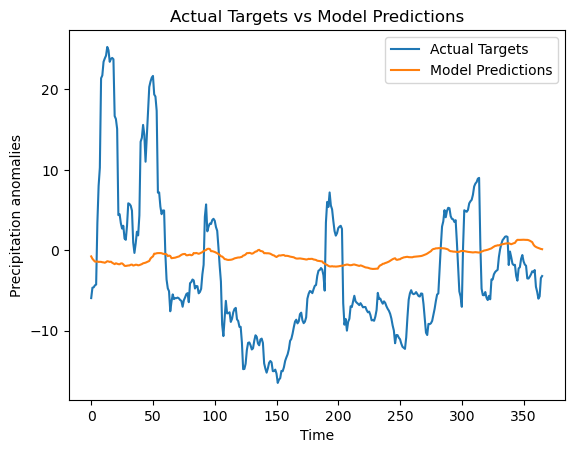

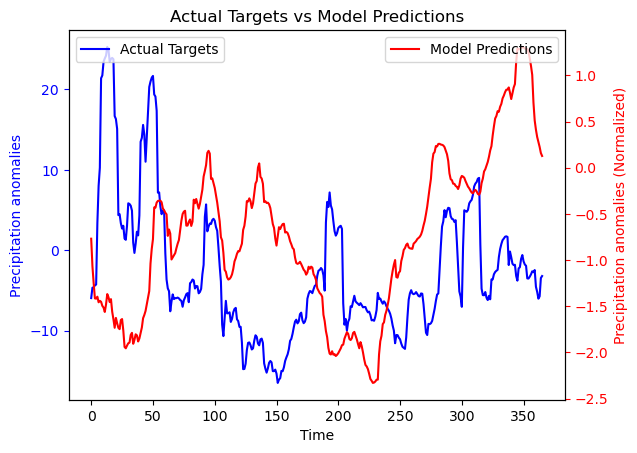

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach

   year           skill
0  2011  0.223893584694
1  2012  0.169640182113
2  2013 -0.070397508031
3  2014 -0.022783183443
4  2015 -0.025781501921
5  2016 -0.000880819349
6  2017  0.036833464584
0.04436060266408281


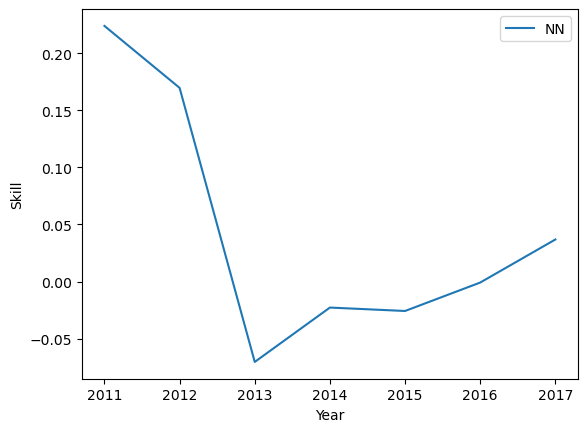

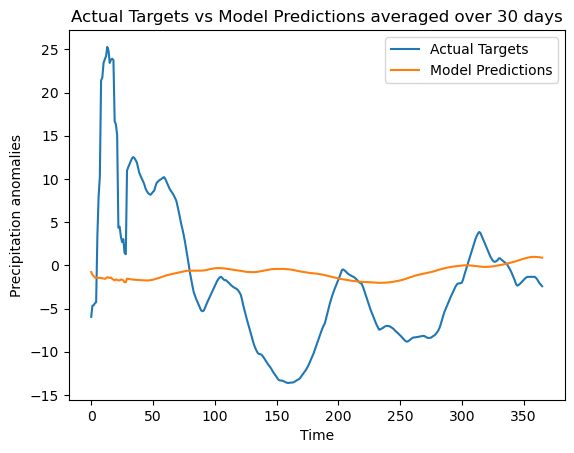

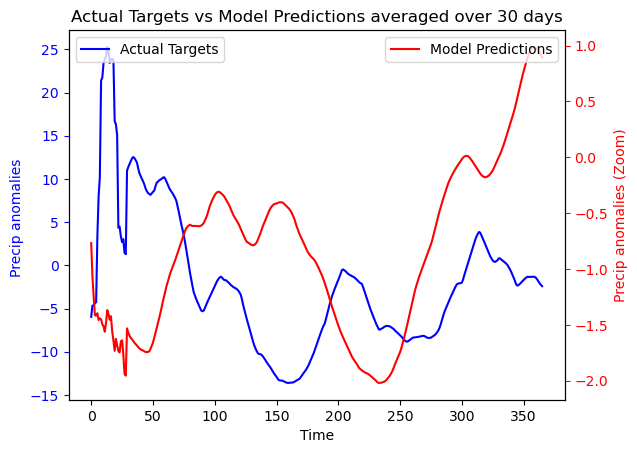

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Permutation explainer: 188125it [19:31, 159.58it/s]                            


[[[[ 0.000000000000e+00  0.000000000000e+00  0.000000000000e+00 ...
     0.000000000000e+00  0.000000000000e+00  0.000000000000e+00]
   [ 0.000000000000e+00  0.000000000000e+00  0.000000000000e+00 ...
     0.000000000000e+00  0.000000000000e+00  0.000000000000e+00]
   [ 0.000000000000e+00  0.000000000000e+00  0.000000000000e+00 ...
     0.000000000000e+00  0.000000000000e+00  0.000000000000e+00]
   ...
   [ 0.000000000000e+00  0.000000000000e+00  0.000000000000e+00 ...
     0.000000000000e+00  0.000000000000e+00  0.000000000000e+00]
   [ 0.000000000000e+00  0.000000000000e+00  0.000000000000e+00 ...
     0.000000000000e+00  0.000000000000e+00  0.000000000000e+00]
   [ 0.000000000000e+00  0.000000000000e+00  0.000000000000e+00 ...
     0.000000000000e+00  0.000000000000e+00  0.000000000000e+00]]

  [[ 0.000000000000e+00  0.000000000000e+00  0.000000000000e+00 ...
     0.000000000000e+00  0.000000000000e+00  0.000000000000e+00]
   [ 0.000000000000e+00  0.000000000000e+00  0.000000000000e

In [1]:
# select all the features possible before running this box. This way you can compare all the features roles.
regularization = 'L1' #Choose between "L1", "L2" or "None"
learning_rate = 0.001
num_epochs = 1 #about 75 seconds per epochs
batch_size = 3000

#data we want to visualize
target_year=2012 #2011 to 2017
latitude = 15 #<23
longitude = 15 #<31
window_size=30 #if we want to plot a moving average instead of daily predictions. Window_size represents the number of days over which data is averaged

#Path and Name of the file you want to save when trained multiple times (sav the skills over each point, averaged over the 4 seasons and the 7 years considered) matrix of size (7,4,23,31).
if gt_id == "contest_tmp2m":
    cache_dir = os.path.join('results', 'tmp2m_' + target_horizon + '_results') #Path 
    name_file_averaged_training = "SHAP_" + str(target_year) + "_tmp2m_" + target_horizon + "_TEST"
if gt_id == "contest_precip":
    cache_dir = os.path.join('results', 'precip_' + target_horizon + '_results') #Path 
    name_file_averaged_training = "SHAP_" + str(target_year) + "_precip_" + target_horizon + "_TEST"

if type_of_norm == "min_max":
    value1 = min_value
    value2 = max_value
if type_of_norm == "mean_std":
    value1 = mean_value
    value2 = std_value

train_loader, val_loader, test_loader, time_test, model_input, test_data, test_targets = one_training_individual(reversed_mask, input_data, target_data, learning_rate, num_epochs, batch_size, datetime_objects, TensorDataset, DataLoader,)
model = model_individual(model_input).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
train_loss, valid_loss = trainer_individual(model, train_loader, val_loader, criterion, optimizer, num_epochs, regularization)
predictions_individual, targets_array_individual, mse, start_date = evaluate_individual(test_data, test_targets, target_year, time_test, value1, value2, model, datetime_objects, reversed_mask, DataLoader, batch_size, type_of_norm)
visualization_one_training(predictions_individual,targets_array_individual, latitude, longitude, gt_id)
visualization_skills_individual(test_data,test_targets,time_test,is_mask, reversed_mask, type_of_norm,model, datetime_objects, DataLoader, batch_size, value1, value2)
visualization_moving_average(predictions_individual, targets_array_individual, latitude, longitude, gt_id, window_size)
predictions_2D, targets_2D, rmse, start_date, shap_values, shap_values_tensor =SHAP_map(test_data, test_targets, target_year, time_test, type_of_norm, reversed_mask, datetime_objects, DataLoader, batch_size, model, value1, value2)
print(shap_values_tensor.shape)

# if cache_dir doesn't exist, create it
if not os.path.isdir(cache_dir):
    os.makedirs(cache_dir)

# Filenames for data file to be stored in cache_dir
data_file = os.path.join(
    cache_dir, name_file_averaged_training)

print("Saving multiarrays features to " + data_file)
th.save(shap_values_tensor, data_file)

print("Finished generating data matrix.")